In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
warnings.filterwarnings("ignore")

In [2]:
"""
                                    Data fields

ID - an Id that represents a (Shop, Item) tuple within the test set
shop_id - unique identifier of a shop
item_id - unique identifier of a product
item_category_id - unique identifier of item category
item_cnt_day - number of products sold. !!!!You are predicting a monthly amount of this measure
item_price - current price of an item
date - date in format dd/mm/yyyy
date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
item_name - name of item
shop_name - name of shop
item_category_name - name of item category

"""

'\n                                    Data fields\n\nID - an Id that represents a (Shop, Item) tuple within the test set\nshop_id - unique identifier of a shop\nitem_id - unique identifier of a product\nitem_category_id - unique identifier of item category\nitem_cnt_day - number of products sold. !!!!You are predicting a monthly amount of this measure\nitem_price - current price of an item\ndate - date in format dd/mm/yyyy\ndate_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33\nitem_name - name of item\nshop_name - name of shop\nitem_category_name - name of item category\n\n'

In [3]:
##загрузка данных
items = pd.read_csv('./items.csv')
shops = pd.read_csv('./shops.csv')
categ = pd.read_csv('./item_categories.csv')
train = pd.read_csv('./sales_train.csv')
test  = pd.read_csv('./test.csv').set_index('ID') #чтобы не потерять индекс

In [6]:
##поиск выбросов
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


<AxesSubplot:xlabel='item_price'>

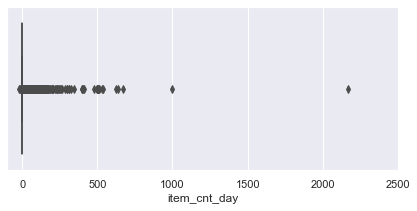

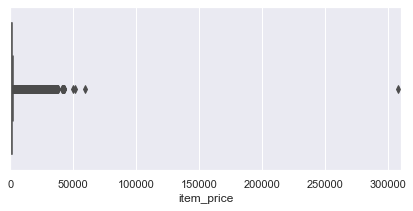

In [7]:
plt.figure(figsize=(7,3))
plt.xlim(-100,2500)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(7,3))
plt.xlim(-2,310000)
sns.boxplot(x=train.item_price)

In [8]:
train = train[train.item_cnt_day < 1001]
train = train[train.item_price < 80000]

In [9]:
#у одного товара цена ниже нуля ---> заменим медианой
train[train.item_price < 0]
#найдем цены на этот 1 товар 2973 в магазине 32 в период 4, чтобы посчитать медиану

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [10]:
median = train[(train.date_block_num == 4)&(train.shop_id == 32)&(train.item_id == 2973)&
               (train.item_cnt_day == 1)&(train.item_price > 0)].item_price.median()

train.loc[train.item_price < 0, 'item_price'] = median

In [11]:
##некоторые магазины имеют дубли названий
# !Якутск Орджоникидзе id=0, 56 фран, Якутск Орджоникидзе, 56 id=57
# !Якутск ТЦ "Центральный" фран id=1, Якутск ТЦ "Центральный id=58
# Жуковский ул. Чкалова 39м² id=10, Жуковский ул. Чкалова 39м? id=11

train.loc[train.shop_id == 0, 'shop_id'] = 57 #Якутск Орджоникидзе, 56
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58 #Якутск ТЦ "Центральный
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 10, 'shop_id'] = 11 #Жуковский ул. Чкалова 39м?
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [12]:
#наблюдения:
#1.Имена магазинов нач-ся с городов, где они расположены
#2.Каждная категория товаров имеет категорию и подкатегорию

In [13]:
#1:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops.shop_name.str.split(' ').map(lambda x: x[0])

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops.city)
shops = shops[['shop_id','city_code']]

In [16]:
#2:
categ['splt'] = categ['item_category_name'].str.split('-')
categ['type'] = categ['splt'].map(lambda x: x[0].strip())
categ['type_code'] = LabelEncoder().fit_transform(categ.type)

In [17]:
categ['subtype'] = categ['splt'].map(lambda x: x[1].strip() if len(x)>1 else x[0].strip())
categ['subtype_code'] = LabelEncoder().fit_transform(categ['subtype'])

In [18]:
categ = categ[[
    'item_category_id',
    'type_code',
    'subtype_code'
]]

In [19]:
items.drop(['item_name'], axis=1, inplace=True)

In [31]:
#Месячные продажи

#Тестовый набор это произведение некоторых магазинов и некоторых продуктов за 34 месяца
#Всего 5100 продуктов и 42 магазина = 214200 пар отношения: (продукт, магазин).
#Сделовательно, для большенства элементов тестового набора целевое значение должно быть равно нулю
#С другой стороны в состав обучающего набора входят только пары, которые были проданы или возвращены в прошлом
#Основная идея - рассчитать месячные продажи и дополнить их нулевыми продажами для каждой уникальной пары, в 
#течении месяца. Т.о. данных из обуч. набора будут аналогичны тестовому набору.

In [57]:
print("Кол-во ун. товаров, которые есть только в тесте:",len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id))))), 
#(уникальные id товаров из теста) - (уникальные id товаров из теста) пересечь (уникальные id nоваров из трейн)
print("Кол-во ун. товаров теста:",len(list(set(test.item_id)))), 
print("Пар (товар, магазин) в тесте:",len(test))

Кол-во ун. товаров, которые есть только в тесте: 363
Кол-во ун. товаров теста: 5100
Пар (товар, магазин) в тесте: 214200


In [87]:
from itertools import product

temp_matrix = []

colms = ['date_block_num','shop_id','item_id']

for i in range(34):
    sales = train[train['date_block_num'] == i]
    #находим все возможные пары (магазин, продукт) для каждого date_block_num
    temp_matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype = 'int16'))

In [88]:
temp_matrix = pd.DataFrame(np.vstack(temp_matrix), columns=colms)
temp_matrix['date_block_num'] = temp_matrix['date_block_num'].astype(np.int8)
temp_matrix['shop_id'] = temp_matrix['shop_id'].astype(np.int8)
temp_matrix['item_id'] = temp_matrix['item_id'].astype(np.int16)

In [89]:
temp_matrix.sort_values(colms, inplace=True)

In [91]:
#Aggregate трейн по паре магазин/продукт для вычисления целевой совокупности, поэтому clip(0,20) целевую переменную
#таким образом трейн target будет схожим с тест предикшинами

In [93]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

In [115]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day' : 'sum'})

In [116]:
group.columns = ['item_cnt_month']

In [118]:
group.reset_index(inplace=True)

In [130]:
temp_matrix = pd.merge(temp_matrix, group, on=colms, how = 'left')
temp_matrix['item_cnt_month'] = (temp_matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))

In [132]:
#Тестовая выборка
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

temp_matrix = pd.concat([temp_matrix, test], ignore_index=True, sort=False, keys=colms)
temp_matrix.fillna(0, inplace=True)

In [134]:
#Магазины/Продукты/Категор. фичи

temp_matrix = pd.merge(temp_matrix, shops, on=['shop_id'], how='left')
temp_matrix = pd.merge(temp_matrix, items, on=['item_id'], how='left')
temp_matrix = pd.merge(temp_matrix, categ, on=['item_category_id'], how='left')
temp_matrix['city_code'] = temp_matrix['city_code'].astype(np.int8)
temp_matrix['item_category_id'] = temp_matrix['item_category_id'].astype(np.int8)
temp_matrix['type_code'] = temp_matrix['type_code'].astype(np.int8)
temp_matrix['subtype_code'] = temp_matrix['subtype_code'].astype(np.int8)

In [136]:
# Traget lags!!!
# Lag features are target values from previous periods.

#For example, if you would like to forecast the sales of a retail outlet in period 𝑡
#you can use the sales of the previous month 𝑡−1 as a feature. 
#That would be a lag of 1 and you could say it models some kind of momentum. 
#But you could also apply a lag of 12 to model the sales of the same month a year ago 
#(since retail sales are often seasonal depending on the format, category and SKU). 
#Accordingly, it depends on the dataset which lags work best and looking at correlation is 
#one way to select the lag values.

In [137]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [138]:
temp_matrix = lag_feature(temp_matrix, [1,2,3,6,12], 'item_cnt_month')

In [140]:
#Mean закодированные фичи
group = temp_matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

temp_matrix = pd.merge(temp_matrix, group, on=['date_block_num'], how='left')
temp_matrix['date_avg_item_cnt'] = temp_matrix['date_avg_item_cnt'].astype(np.float16)
temp_matrix = lag_feature(temp_matrix, [1], 'date_avg_item_cnt')
temp_matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [141]:
group = temp_matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

temp_matrix = pd.merge(temp_matrix, group, on=['date_block_num','item_id'], how='left')
temp_matrix['date_item_avg_item_cnt'] = temp_matrix['date_item_avg_item_cnt'].astype(np.float16)
temp_matrix = lag_feature(temp_matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
temp_matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [142]:
group = temp_matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

temp_matrix = pd.merge(temp_matrix, group, on=['date_block_num','shop_id'], how='left')
temp_matrix['date_shop_avg_item_cnt'] = temp_matrix['date_shop_avg_item_cnt'].astype(np.float16)
temp_matrix = lag_feature(temp_matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
temp_matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [143]:
group = temp_matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

temp_matrix = pd.merge(temp_matrix, group, on=['date_block_num','item_category_id'], how='left')
temp_matrix['date_cat_avg_item_cnt'] = temp_matrix['date_cat_avg_item_cnt'].astype(np.float16)
temp_matrix = lag_feature(temp_matrix, [1], 'date_cat_avg_item_cnt')
temp_matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [144]:
group = temp_matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

temp_matrix = pd.merge(temp_matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
temp_matrix['date_shop_cat_avg_item_cnt'] = temp_matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
temp_matrix = lag_feature(temp_matrix, [1], 'date_shop_cat_avg_item_cnt')
temp_matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [145]:
group = temp_matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

temp_matrix = pd.merge(temp_matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
temp_matrix['date_shop_type_avg_item_cnt'] = temp_matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
temp_matrix = lag_feature(temp_matrix, [1], 'date_shop_type_avg_item_cnt')
temp_matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [146]:
group = temp_matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

temp_matrix = pd.merge(temp_matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
temp_matrix['date_shop_subtype_avg_item_cnt'] = temp_matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)


NameError: name 'matrix' is not defined

In [147]:
temp_matrix = lag_feature(temp_matrix, [1], 'date_shop_subtype_avg_item_cnt')
temp_matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [148]:
group = temp_matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

temp_matrix = pd.merge(temp_matrix, group, on=['date_block_num', 'city_code'], how='left')
temp_matrix['date_city_avg_item_cnt'] = temp_matrix['date_city_avg_item_cnt'].astype(np.float16)
temp_matrix = lag_feature(temp_matrix, [1], 'date_city_avg_item_cnt')
temp_matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [149]:
group = temp_matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

temp_matrix = pd.merge(temp_matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
temp_matrix['date_item_city_avg_item_cnt'] = temp_matrix['date_item_city_avg_item_cnt'].astype(np.float16)
temp_matrix = lag_feature(temp_matrix, [1], 'date_item_city_avg_item_cnt')
temp_matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [150]:
group = temp_matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

temp_matrix = pd.merge(temp_matrix, group, on=['date_block_num', 'type_code'], how='left')
temp_matrix['date_type_avg_item_cnt'] = temp_matrix['date_type_avg_item_cnt'].astype(np.float16)
temp_matrix = lag_feature(temp_matrix, [1], 'date_type_avg_item_cnt')
temp_matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [151]:
group = temp_matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

temp_matrix = pd.merge(temp_matrix, group, on=['date_block_num', 'subtype_code'], how='left')
temp_matrix['date_subtype_avg_item_cnt'] = temp_matrix['date_subtype_avg_item_cnt'].astype(np.float16)
temp_matrix = lag_feature(temp_matrix, [1], 'date_subtype_avg_item_cnt')
temp_matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

In [152]:
#Trend features

In [153]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

temp_matrix = pd.merge(temp_matrix, group, on=['item_id'], how='left')
temp_matrix['item_avg_item_price'] = temp_matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

temp_matrix = pd.merge(temp_matrix, group, on=['date_block_num','item_id'], how='left')
temp_matrix['date_item_avg_item_price'] = temp_matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
temp_matrix = lag_feature(temp_matrix, lags, 'date_item_avg_item_price')

for i in lags:
    temp_matrix['delta_price_lag_'+str(i)] = \
        (temp_matrix['date_item_avg_item_price_lag_'+str(i)] - temp_matrix['item_avg_item_price']) / temp_matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
temp_matrix['delta_price_lag'] = temp_matrix.apply(select_trend, axis=1)
temp_matrix['delta_price_lag'] = temp_matrix['delta_price_lag'].astype(np.float16)
temp_matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

temp_matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [ ]:
#Тренд заработка последнего месяца для магазина

In [ ]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

temp_matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
temp_matrix['date_shop_revenue'] = temp_matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

temp_matrix = pd.merge(temp_matrix, group, on=['shop_id'], how='left')
temp_matrix['shop_avg_revenue'] = temp_matrix['shop_avg_revenue'].astype(np.float32)

temp_matrix['delta_revenue'] = (temp_matrix['date_shop_revenue'] - temp_matrix['shop_avg_revenue']) / temp_matrix['shop_avg_revenue']
temp_matrix['delta_revenue'] = temp_matrix['delta_revenue'].astype(np.float16)

temp_matrix = lag_feature(temp_matrix, [1], 'delta_revenue')

temp_matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [ ]:
temp_matrix['month'] = temp_matrix['date_block_num'] % 12

In [ ]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
temp_matrix['days'] = temp_matrix['month'].map(days).astype(np.int8)

In [ ]:
#Months since the last sale for each shop/item pair and for item only.

#Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. 
#Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, 
#then add it to the table and set its value to row.date_block_num. if HashTable contains key, 
#then calculate the difference beteween cached value and row.date_block_num.

In [ ]:
cache = {}
temp_matrix['item_shop_last_sale'] = -1
temp_matrix['item_shop_last_sale'] = temp_matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in temp_matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        temp_matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num

In [ ]:
cache = {}
temp_matrix['item_last_sale'] = -1
temp_matrix['item_last_sale'] = temp_matrix['item_last_sale'].astype(np.int8)
for idx, row in temp_matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            temp_matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num

In [ ]:
temp_matrix['item_shop_first_sale'] = temp_matrix['date_block_num'] - temp_matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
temp_matrix['item_first_sale'] = temp_matrix['date_block_num'] - temp_matrix.groupby('item_id')['date_block_num'].transform('min')

In [ ]:
#Final preparations
#Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month 
#calculated values (other words which can not be calcucated for the test set).

In [ ]:
matrix = matrix[matrix.date_block_num > 11]

In [ ]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

temp_matrix = fill_na(temp_matrix)

In [ ]:
temp_matrix.columns

In [ ]:
temp_matrix.info()

In [ ]:
temp_matrix.to_pickle('data.pkl')
del temp_matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

In [ ]:
data = pd.read_pickle('data.pkl')

In [ ]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [ ]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
del data
gc.collect();

In [ ]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

In [ ]:
plot_features(model, (10,14))